##### Imports

In [1]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [4]:
DATA_STORE = Path('/home/sayem/Desktop/Project/data/assets.h5')

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    print(store.keys())

['/us_equities/stocks', '/stooq/us/nyse/stocks/prices', '/stooq/us/nyse/stocks/tickers', '/stooq/us/nyse/etfs/prices', '/stooq/us/nyse/etfs/tickers', '/stooq/us/nasdaq/stocks/prices', '/stooq/us/nasdaq/stocks/tickers', '/stooq/us/nasdaq/etfs/prices', '/stooq/us/nasdaq/etfs/tickers', '/sp500/fred_price', '/sp500/stocks_name']


In [6]:
with pd.HDFStore(DATA_STORE) as store:
    nyse_stocks = store['/stooq/us/nyse/stocks/prices']
    nasdaq_stocks = store['/stooq/us/nasdaq/stocks/prices']
    metadata = store['us_equities/stocks'].loc[:, ['market cap', 'sector']]

In [7]:
# Concatenate the two DataFrames
data = pd.concat([nyse_stocks, nasdaq_stocks])

# Drop NaN values and duplicates
data = data.dropna().drop_duplicates()

# Display the cleaned DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11958377 entries, ('', Timestamp('2013-01-02 00:00:00')) to ('ZYXI', Timestamp('2023-08-11 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 502.2+ MB
None


In [8]:
metadata.sector = pd.factorize(metadata.sector)[0]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7516 entries, AACG to ZWS
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   market cap  7078 non-null   float64
 1   sector      7516 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 176.2+ KB


In [9]:
data = data.join(metadata).dropna(subset=['sector'])

In [10]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 6,700 | # Dates: 2,671


In [11]:
# Identifying duplicate entries based on index
duplicates = data[data.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [open, high, low, close, volume, market cap, sector]
Index: []


##### Select 500 most-traded stocks

In [12]:
dv = data.close.mul(data.volume)
dv = dv[~dv.index.duplicated(keep='first')]

In [13]:
top = 250
locals()[f'top{top}'] = (dv.groupby(level='date')
                         .rank(ascending=False)
                         .unstack('ticker')
                         .dropna(thresh=8*252, axis=1)
                         .mean()
                         .nsmallest(top))

##### Visualize the 200 most liquid stocks

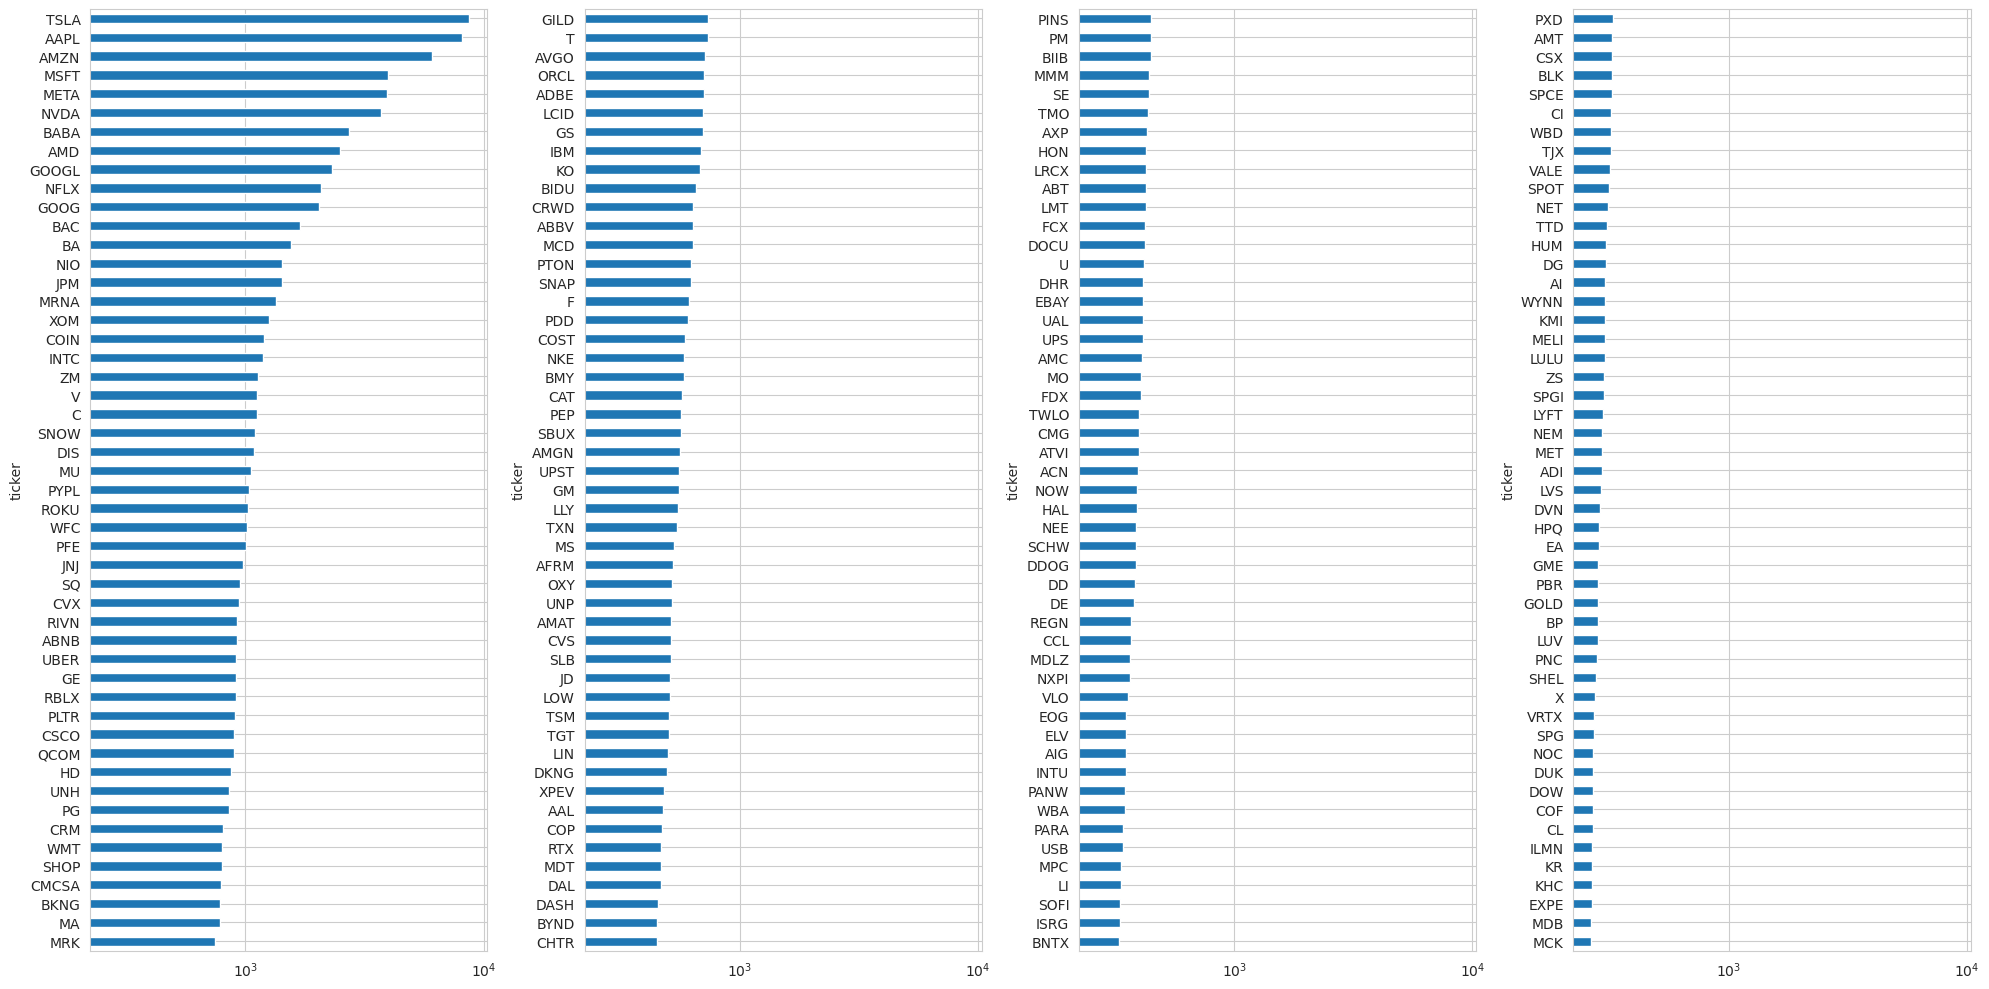

In [14]:
dv = data.close.mul(data.volume).div(1e6)  # scaling values to millions
dv = dv[~dv.index.duplicated(keep='first')]

# Group by date and ticker, then by ticker alone
avg_dv_per_ticker = dv.groupby(level=['date', 'ticker']).mean().groupby(level='ticker').mean()

# Get top 200 tickers based on the average dollar volume
top200_tickers = avg_dv_per_ticker.nlargest(200)

cutoffs = [0, 50, 100, 150, 200]
fig, axes = plt.subplots(ncols=4, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i, cutoff in enumerate(cutoffs[1:], 1):
    top200_tickers.iloc[cutoffs[i-1]:cutoffs[i]].sort_values().plot.barh(logx=True, ax=axes[i-1])

fig.tight_layout()

In [15]:
to_drop = data.index.unique('ticker').difference(locals()[f'top{top}'].index)

In [16]:
len(to_drop)

6450

In [17]:
data = data.drop(to_drop, level='ticker')

In [18]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 673128 entries, ('AA', Timestamp('2013-01-02 00:00:00')) to ('WYNN', Timestamp('2023-08-11 00:00:00'))
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   open        673128 non-null  float64
 1   high        673128 non-null  float64
 2   low         673128 non-null  float64
 3   close       673128 non-null  float64
 4   volume      673128 non-null  float64
 5   market cap  673128 non-null  float64
 6   sector      673128 non-null  float64
dtypes: float64(7)
memory usage: 38.9+ MB


In [19]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 250 | # Dates: 2,671


##### Remove outlier observations based on daily returns

In [20]:
before = len(data)
data['ret'] = data.groupby('ticker').close.pct_change()
data = data[data.ret.between(-1, 1)].drop('ret', axis=1)
print(f'Dropped {before-len(data):,.0f}')

Dropped 1,665


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 671463 entries, ('AA', Timestamp('2013-01-03 00:00:00')) to ('WYNN', Timestamp('2023-08-11 00:00:00'))
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   open        671463 non-null  float64
 1   high        671463 non-null  float64
 2   low         671463 non-null  float64
 3   close       671463 non-null  float64
 4   volume      671463 non-null  float64
 5   market cap  671463 non-null  float64
 6   sector      671463 non-null  float64
dtypes: float64(7)
memory usage: 38.8+ MB


In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df, ticker):
    # Extract relevant data for the ticker
    ticker_data = df.loc[ticker]
    
    # Ensure data covers at least 2 years, otherwise return a message
    if len(ticker_data) < 2 * 252:  # Assuming 252 trading days in a year
        return f"Insufficient data for {ticker}. Need at least 2 years of data."

    # Calculate log and percentage returns
    ticker_data['log_ret'] = np.log(ticker_data['close'] / ticker_data['close'].shift(1))
    ticker_data['pct_ret'] = ticker_data['close'].pct_change()

    # Drop NaN values (the first row after computing returns)
    ticker_data = ticker_data.dropna()

    # Test stationarity for each series using ADF
    adf_price = adfuller(ticker_data['close'])
    adf_log_ret = adfuller(ticker_data['log_ret'])
    adf_pct_ret = adfuller(ticker_data['pct_ret'])
    
    # Store results in a dictionary for comparison
    results = {
        'price': adf_price[0],
        'log_ret': adf_log_ret[0],
        'pct_ret': adf_pct_ret[0]
    }
    # Find which series is the most stationary based on the ADF statistic (the lower, the better)
    most_stationary = min(results, key=results.get)
    
    return most_stationary, results

# Example usage:
ticker = 'AAPL'  # Replace with desired ticker
most_stationary, results = test_stationarity(data, ticker)
print(f"For {ticker}, the most stationary series is: {most_stationary}.")
print("ADF Results:", results)

For AAPL, the most stationary series is: pct_ret.
ADF Results: {'price': 0.4633927548084181, 'log_ret': -16.492797724238496, 'pct_ret': -16.585440873113704}


In [23]:
tickers = data.index.unique('ticker')
print(f"# Tickers: {len(tickers):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 250 | # Dates: 2,671


##### Compute returns
- Frac diff

In [24]:
import numpy as np
import pandas as pd
from tsfracdiff import FractionalDifferentiator

def process_tickers(df, num_tickers=None):
    processed_dfs = []

    # If num_tickers is not provided, process all tickers
    if num_tickers is None:
        ticker_groups = list(df.groupby(level=0))
    else:
        ticker_groups = list(df.groupby(level=0))[:num_tickers]

    for ticker, group in ticker_groups:
        group_copy = group.copy()

        # Calculate X_frac 
        frac_diff = FractionalDifferentiator()
        X_frac = frac_diff.FitTransform(group_copy[['close']])
    
        # The number of NaN values needed to align X_frac with close
        nans_needed = len(group_copy) - len(X_frac)

        # Create a NaN series of required length
        nan_series = pd.Series([np.nan] * nans_needed)

        # Append the NaN series to the start of X_frac
        X_frac_aligned = nan_series.append(X_frac['close']).reset_index(drop=True)

        # Add the aligned X_frac to the group
        column_name = f"ret_frac_order"
        group_copy[column_name] = X_frac_aligned.values

        processed_dfs.append(group_copy)

    # Concatenate all processed dataframes
    result_df = pd.concat(processed_dfs)

    return result_df

# Process all tickers
data = process_tickers(data.copy())

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 671463 entries, ('AA', Timestamp('2013-01-03 00:00:00')) to ('ZTS', Timestamp('2023-08-11 00:00:00'))
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   open            671463 non-null  float64
 1   high            671463 non-null  float64
 2   low             671463 non-null  float64
 3   close           671463 non-null  float64
 4   volume          671463 non-null  float64
 5   market cap      671463 non-null  float64
 6   sector          671463 non-null  float64
 7   ret_frac_order  586621 non-null  float64
dtypes: float64(8)
memory usage: 43.6+ MB


In [26]:
data

open      high       low     close        volume  \
ticker date                                                               
AA     2013-01-03   18.9041   19.3065   18.8832   19.1376  1.057118e+07   
       2013-01-04   19.2220   19.5798   19.2003   19.5371  8.690739e+06   
       2013-01-07   19.5371   19.6006   19.2003   19.2003  1.031992e+07   
       2013-01-08   19.3274   19.3891   19.1584   19.2003  1.609879e+07   
       2013-01-09   19.6851   19.6851   19.1157   19.1584  1.979932e+07   
...                     ...       ...       ...       ...           ...   
ZTS    2023-08-07  180.1900  181.8800  180.0300  180.6900  1.941699e+06   
       2023-08-08  182.1500  190.5400  177.2500  189.3000  4.117986e+06   
       2023-08-09  189.9400  190.9500  186.9650  189.3500  2.270030e+06   
       2023-08-10  190.0000  191.8250  187.7300  189.1000  2.348639e+06   
       2023-08-11  188.4800  191.6000  188.1800  190.8300  1.742931e+06   

                     market cap  sector  ret_frac_order  
ticker date                                              
AA     2013-01-03  5.703249e+09     4.0             NaN  
       2013-01-04  5.703249e+09     4.0             NaN  
       2013-01-07  5.703249e+09     4.0             NaN  
       2013-01-08  5.703249e+09     4.0             NaN  
       2013-01-09  5.703249e+09     4.0             NaN  
...                         ...     ...             ...  
ZTS    2023-08-07  8.818486e+10     2.0       16.669206  
       2023-08-08  8.818486e+10     2.0       24.922549  
       2023-08-09  8.818486e+10     2.0       21.726665  
       2023-08-10  8.818486e+10     2.0       20.455498  
       2023-08-11  8.818486e+10     2.0       21.730034  

[671463 rows x 8 columns]

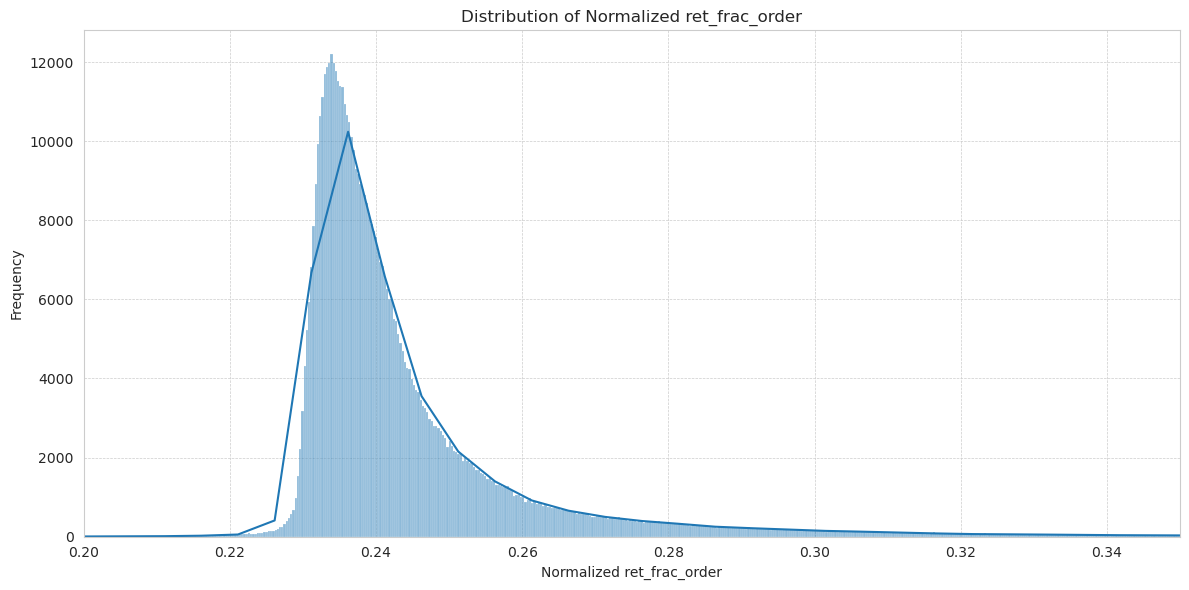

In [27]:
# Removing NaN values from 'ret_frac_order' for the analysis
data_filtered = data['ret_frac_order'].dropna()

# Normalize the data
data_min = data_filtered.min()
data_max = data_filtered.max()
normalized_data = (data_filtered - data_min) \
    / (data_max - data_min)

# Plot the distribution of the normalized data
plt.figure(figsize=(12, 6))

# Adjust the x-scale
plt.xlim(0.20, 0.35)

sns.histplot(normalized_data, bins="auto", kde=True)
plt.title('Distribution of Normalized ret_frac_order')
plt.xlabel('Normalized ret_frac_order')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

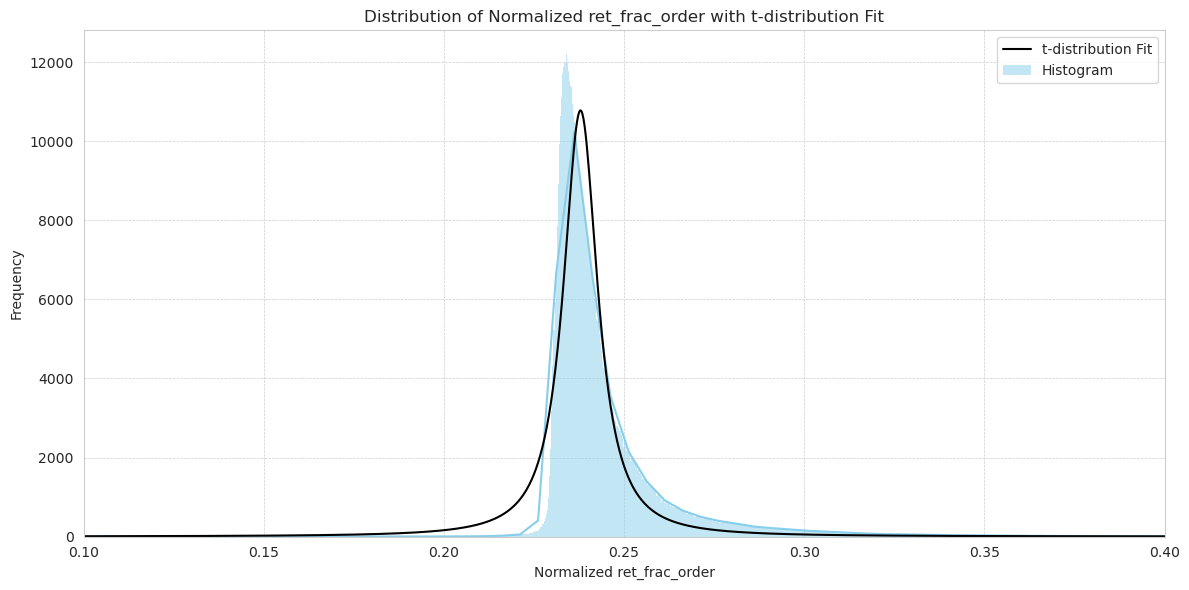

In [28]:
from scipy.stats import t
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Removing NaN values from 'ret_frac_order' for the analysis
data_filtered = data['ret_frac_order'].dropna()

# Normalize the data
data_min = data_filtered.min()
data_max = data_filtered.max()
normalized_data = (data_filtered - data_min) \
    / (data_max - data_min)

# Fit a t-distribution to the data
params = t.fit(normalized_data)

# Plot the histogram of the data
plt.figure(figsize=(12, 6))
sns.histplot(normalized_data, bins="auto", kde=True, color="skyblue", label="Histogram")
plt.title('Distribution of Normalized ret_frac_order with t-distribution Fit')
plt.xlabel('Normalized ret_frac_order')
plt.ylabel('Frequency')

# Adjust the x-scale
plt.xlim(0.1, 0.4)

# Overlay the fitted t-distribution
x = np.linspace(0.1, 0.4, 1000)
pdf_fitted = t.pdf(x, *params)
plt.plot(x, pdf_fitted * len(normalized_data) * (x[1] - x[0]), '-k', label="t-distribution Fit")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

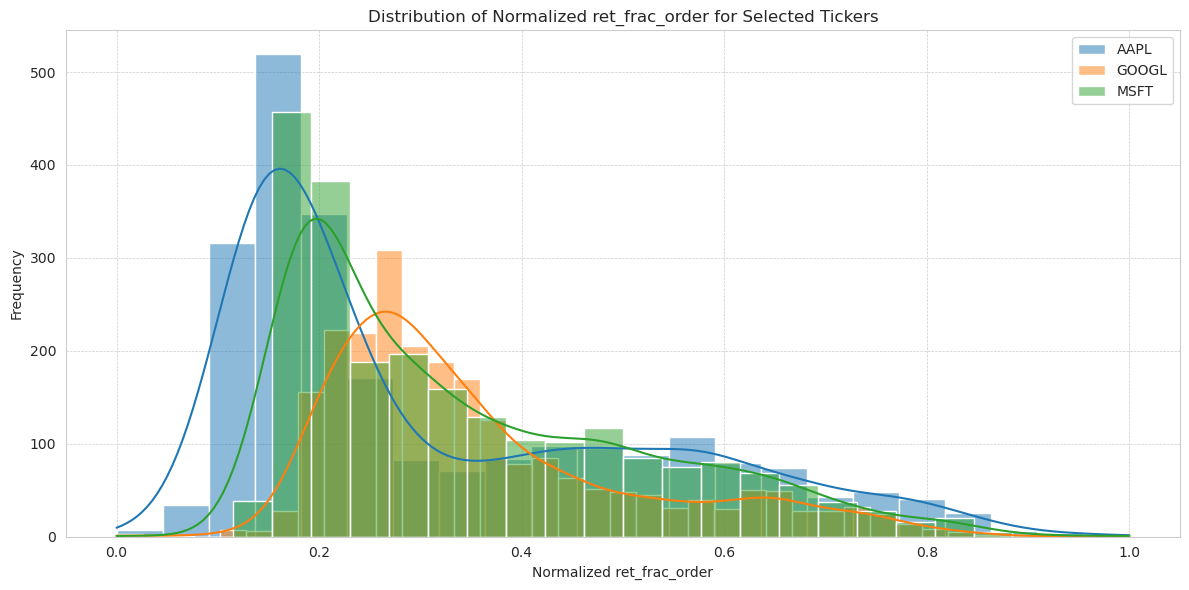

In [29]:
# Define the tickers for which you want to plot the distribution
tickers_to_plot = ['AAPL', 'GOOGL', 'MSFT']  # example tickers

plt.figure(figsize=(12, 6))

# Loop through each ticker and plot the distribution
for ticker in tickers_to_plot:
    # Filter the data for the specified ticker
    ticker_data = data_filtered.loc[ticker]
    
    # Normalize the ticker_data
    data_min = ticker_data.min()
    data_max = ticker_data.max()
    normalized_ticker_data = (ticker_data - data_min) / (data_max - data_min)

    # Plot the distribution of the normalized data for the given ticker
    sns.histplot(normalized_ticker_data, bins="auto", kde=True, label=ticker)

plt.title(f'Distribution of Normalized ret_frac_order for Selected Tickers')
plt.xlabel('Normalized ret_frac_order')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

- Historical returns

In [30]:
T = [1, 2, 3, 4, 5, 10, 21, 42, 63, 126, 252]

by_ticker = data.groupby(level='ticker')

for t in T:
    col_name = f'ret_{t:02}d'
    data[col_name] = by_ticker.close.pct_change(t)
    
    # Fill NaN values in the column using forward fill, followed by backward fill
    data[col_name] = data[col_name].fillna(method='ffill').fillna(method='bfill')

In [31]:
data

open      high       low     close        volume  \
ticker date                                                               
AA     2013-01-03   18.9041   19.3065   18.8832   19.1376  1.057118e+07   
       2013-01-04   19.2220   19.5798   19.2003   19.5371  8.690739e+06   
       2013-01-07   19.5371   19.6006   19.2003   19.2003  1.031992e+07   
       2013-01-08   19.3274   19.3891   19.1584   19.2003  1.609879e+07   
       2013-01-09   19.6851   19.6851   19.1157   19.1584  1.979932e+07   
...                     ...       ...       ...       ...           ...   
ZTS    2023-08-07  180.1900  181.8800  180.0300  180.6900  1.941699e+06   
       2023-08-08  182.1500  190.5400  177.2500  189.3000  4.117986e+06   
       2023-08-09  189.9400  190.9500  186.9650  189.3500  2.270030e+06   
       2023-08-10  190.0000  191.8250  187.7300  189.1000  2.348639e+06   
       2023-08-11  188.4800  191.6000  188.1800  190.8300  1.742931e+06   

                     market cap  sector  ret_frac_order   ret_01d   ret_02d  \
ticker date                                                                   
AA     2013-01-03  5.703249e+09     4.0             NaN  0.020875  0.003276   
       2013-01-04  5.703249e+09     4.0             NaN  0.020875  0.003276   
       2013-01-07  5.703249e+09     4.0             NaN -0.017239  0.003276   
       2013-01-08  5.703249e+09     4.0             NaN  0.000000 -0.017239   
       2013-01-09  5.703249e+09     4.0             NaN -0.002182 -0.002182   
...                         ...     ...             ...       ...       ...   
ZTS    2023-08-07  8.818486e+10     2.0       16.669206  0.011532 -0.001050   
       2023-08-08  8.818486e+10     2.0       24.922549  0.047651  0.059732   
       2023-08-09  8.818486e+10     2.0       21.726665  0.000264  0.047927   
       2023-08-10  8.818486e+10     2.0       20.455498 -0.001320 -0.001057   
       2023-08-11  8.818486e+10     2.0       21.730034  0.009149  0.007816   

                    ret_03d   ret_04d   ret_05d   ret_10d   ret_21d   ret_42d  \
ticker date                                                                     
AA     2013-01-03  0.003276  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
       2013-01-04  0.003276  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
       2013-01-07  0.003276  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
       2013-01-08  0.003276  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
       2013-01-09 -0.019384  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
...                     ...       ...       ...       ...       ...       ...   
ZTS    2023-08-07 -0.007198 -0.025982 -0.039343 -0.026350  0.081070  0.062008   
       2023-08-08  0.046550  0.040110  0.020430 -0.004470  0.112090  0.157232   
       2023-08-09  0.060012  0.046827  0.040385 -0.013802  0.112907  0.152465   
       2023-08-10  0.046544  0.058613  0.045444  0.002173  0.100314  0.159482   
       2023-08-11  0.008082  0.056118  0.068298  0.004897  0.115965  0.152703   

                    ret_63d  ret_126d  ret_252d  
ticker date                                      
AA     2013-01-03 -0.088433 -0.133089  0.181219  
       2013-01-04 -0.088433 -0.133089  0.181219  
       2013-01-07 -0.088433 -0.133089  0.181219  
       2013-01-08 -0.088433 -0.133089  0.181219  
       2013-01-09 -0.088433 -0.133089  0.181219  
...                     ...       ...       ...  
ZTS    2023-08-07 -0.029748  0.076818  0.038806  
       2023-08-08  0.023963  0.147760  0.086433  
       2023-08-09  0.027011  0.143625  0.090468  
       2023-08-10  0.021389  0.166780  0.117672  
       2023-08-11  0.030845  0.186680  0.098675  

[671463 rows x 19 columns]

##### Forward returns

In [32]:
# Create forward shifted column
data['ret_fwd_frac_order'] = data['ret_frac_order'].shift(-1)

# Fill NaN values using forward fill
data['ret_fwd_frac_order'].fillna(method='ffill', inplace=True)

In [33]:
T = [1, 2, 3, 4, 5, 10, 21, 42, 63, 126, 252]

by_ticker = data.groupby(level='ticker')

# Create forward shifted columns for each t in T
for t in T:
    col_name = f'ret_fwd_{t:02}d'
    data[col_name] = by_ticker[f'ret_{t:02}d'].shift(-1)
    
#     # Fill NaN values in the forward shifted column using forward fill, followed by backward fill
#     data[col_name] = data[col_name].fillna(method='ffill').fillna(method='bfill')

# # If after filling there are still rows with NaN values that you wish to drop (which might be rare after both fill methods):
# data = data.dropna(subset=[f'ret_fwd_{t:02}d' for t in T])

In [34]:
data

open      high       low     close        volume  \
ticker date                                                               
AA     2013-01-03   18.9041   19.3065   18.8832   19.1376  1.057118e+07   
       2013-01-04   19.2220   19.5798   19.2003   19.5371  8.690739e+06   
       2013-01-07   19.5371   19.6006   19.2003   19.2003  1.031992e+07   
       2013-01-08   19.3274   19.3891   19.1584   19.2003  1.609879e+07   
       2013-01-09   19.6851   19.6851   19.1157   19.1584  1.979932e+07   
...                     ...       ...       ...       ...           ...   
ZTS    2023-08-07  180.1900  181.8800  180.0300  180.6900  1.941699e+06   
       2023-08-08  182.1500  190.5400  177.2500  189.3000  4.117986e+06   
       2023-08-09  189.9400  190.9500  186.9650  189.3500  2.270030e+06   
       2023-08-10  190.0000  191.8250  187.7300  189.1000  2.348639e+06   
       2023-08-11  188.4800  191.6000  188.1800  190.8300  1.742931e+06   

                     market cap  sector  ret_frac_order   ret_01d   ret_02d  \
ticker date                                                                   
AA     2013-01-03  5.703249e+09     4.0             NaN  0.020875  0.003276   
       2013-01-04  5.703249e+09     4.0             NaN  0.020875  0.003276   
       2013-01-07  5.703249e+09     4.0             NaN -0.017239  0.003276   
       2013-01-08  5.703249e+09     4.0             NaN  0.000000 -0.017239   
       2013-01-09  5.703249e+09     4.0             NaN -0.002182 -0.002182   
...                         ...     ...             ...       ...       ...   
ZTS    2023-08-07  8.818486e+10     2.0       16.669206  0.011532 -0.001050   
       2023-08-08  8.818486e+10     2.0       24.922549  0.047651  0.059732   
       2023-08-09  8.818486e+10     2.0       21.726665  0.000264  0.047927   
       2023-08-10  8.818486e+10     2.0       20.455498 -0.001320 -0.001057   
       2023-08-11  8.818486e+10     2.0       21.730034  0.009149  0.007816   

                    ret_03d   ret_04d   ret_05d   ret_10d   ret_21d   ret_42d  \
ticker date                                                                     
AA     2013-01-03  0.003276  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
       2013-01-04  0.003276  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
       2013-01-07  0.003276  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
       2013-01-08  0.003276  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
       2013-01-09 -0.019384  0.001087 -0.011062 -0.014385 -0.023211 -0.051981   
...                     ...       ...       ...       ...       ...       ...   
ZTS    2023-08-07 -0.007198 -0.025982 -0.039343 -0.026350  0.081070  0.062008   
       2023-08-08  0.046550  0.040110  0.020430 -0.004470  0.112090  0.157232   
       2023-08-09  0.060012  0.046827  0.040385 -0.013802  0.112907  0.152465   
       2023-08-10  0.046544  0.058613  0.045444  0.002173  0.100314  0.159482   
       2023-08-11  0.008082  0.056118  0.068298  0.004897  0.115965  0.152703   

                    ret_63d  ret_126d  ret_252d  ret_fwd_frac_order  \
ticker date                                                           
AA     2013-01-03 -0.088433 -0.133089  0.181219                 NaN   
       2013-01-04 -0.088433 -0.133089  0.181219                 NaN   
       2013-01-07 -0.088433 -0.133089  0.181219                 NaN   
       2013-01-08 -0.088433 -0.133089  0.181219                 NaN   
       2013-01-09 -0.088433 -0.133089  0.181219                 NaN   
...                     ...       ...       ...                 ...   
ZTS    2023-08-07 -0.029748  0.076818  0.038806           24.922549   
       2023-08-08  0.023963  0.147760  0.086433           21.726665   
       2023-08-09  0.027011  0.143625  0.090468           20.455498   
       2023-08-10  0.021389  0.166780  0.117672           21.730034   
       2023-08-11  0.030845  0.186680  0.098675           21.730034   

                   ret_fwd_01d  ret_fwd_0

##### Persist results

In [35]:
import pandas as pd
import gc
from utils import optimize_dataframe


data.rename(columns={'market cap': \
    'market_cap'}, inplace=True)

df_optimized = optimize_dataframe(data.copy())

Data memory before optimization: 161.48 MB
Data memory after optimization: 87.19 MB
Reduced by: 46.00%


In [36]:
df_optimized

open        high         low       close  \
ticker date                                                         
AA     2013-01-03   18.904100   19.306499   18.883200   19.137600   
       2013-01-04   19.222000   19.579800   19.200300   19.537100   
       2013-01-07   19.537100   19.600599   19.200300   19.200300   
       2013-01-08   19.327400   19.389099   19.158400   19.200300   
       2013-01-09   19.685101   19.685101   19.115700   19.158400   
...                       ...         ...         ...         ...   
ZTS    2023-08-07  180.190002  181.880005  180.029999  180.690002   
       2023-08-08  182.149994  190.539993  177.250000  189.300003   
       2023-08-09  189.940002  190.949997  186.964996  189.350006   
       2023-08-10  190.000000  191.824997  187.729996  189.100006   
       2023-08-11  188.479996  191.600006  188.179993  190.830002   

                         volume    market_cap  sector  ret_frac_order  \
ticker date                                                             
AA     2013-01-03  1.057118e+07  5.703249e+09     4.0        8.914233   
       2013-01-04  8.690739e+06  5.703249e+09     4.0        8.914233   
       2013-01-07  1.031992e+07  5.703249e+09     4.0        8.914233   
       2013-01-08  1.609879e+07  5.703249e+09     4.0        8.914233   
       2013-01-09  1.979932e+07  5.703249e+09     4.0        8.914233   
...                         ...           ...     ...             ...   
ZTS    2023-08-07  1.941699e+06  8.818486e+10     2.0       16.669207   
       2023-08-08  4.117986e+06  8.818486e+10     2.0       24.922548   
       2023-08-09  2.270030e+06  8.818486e+10     2.0       21.726665   
       2023-08-10  2.348639e+06  8.818486e+10     2.0       20.455498   
       2023-08-11  1.742931e+06  8.818486e+10     2.0       21.730034   

                    ret_01d   ret_02d   ret_03d   ret_04d   ret_05d   ret_10d  \
ticker date                                                                     
AA     2013-01-03  0.020875  0.003276  0.003276  0.001087 -0.011062 -0.014385   
       2013-01-04  0.020875  0.003276  0.003276  0.001087 -0.011062 -0.014385   
       2013-01-07 -0.017239  0.003276  0.003276  0.001087 -0.011062 -0.014385   
       2013-01-08  0.000000 -0.017239  0.003276  0.001087 -0.011062 -0.014385   
       2013-01-09 -0.002182 -0.002182 -0.019384  0.001087 -0.011062 -0.014385   
...                     ...       ...       ...       ...       ...       ...   
ZTS    2023-08-07  0.011532 -0.001050 -0.007198 -0.025982 -0.039343 -0.026350   
       2023-08-08  0.047651  0.059732  0.046550  0.040110  0.020430 -0.004470   
       2023-08-09  0.000264  0.047927  0.060012  0.046827  0.040385 -0.013802   
       2023-08-10 -0.001320 -0.001057  0.046544  0.058613  0.045444  0.002173   
       2023-08-11  0.009149  0.007816  0.008082  0.056118  0.068298  0.004897   

                    ret_21d   ret_42d   ret_63d  ret_126d  ret_252d  \
ticker date                                                           
AA     2013-01-03 -0.023211 -0.051981 -0.088433 -0.133089  0.181219   
       2013-01-04 -0.023211 -0.051981 -0.088433 -0.133089  0.181219   
       2013-01-07 -0.023211 -0.051981 -0.088433 -0.133089  0.181219   
       2013-01-08 -0.023211 -0.051981 -0.088433 -0.133089  0.181219   
       2013-01-09 -0.023211 -0.051981 -0.088433 -0.133089  0.181219   
...                     ...       ...       ...       ...       ...   
ZTS    2023-08-07  0.081070  0.062008 -0.029748  0.076818  0.038806   
       2023-08-08  0.112090  0.157232  0.023963  0.147760  0.086433   
       2023-08-09  0.112907  0.152465  0.027011  0.143625  0.090468   
       2023-08-10  0.100314  0.159482  0.021389  0.166780  0.117672   
       2023-08-11  0.115965  0.152703  0.030845  0.186680  0.098675   

                   ret_fwd_frac_order  ret_fwd_01d  ret_fwd_02d  ret_fwd_03d  \
ticker date                                                                    
AA     2013-01-03            8.914233  

In [37]:
df_optimized.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 671463 entries, ('AA', Timestamp('2013-01-03 00:00:00')) to ('ZTS', Timestamp('2023-08-11 00:00:00'))
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   open                671463 non-null  float32
 1   high                671463 non-null  float32
 2   low                 671463 non-null  float32
 3   close               671463 non-null  float32
 4   volume              671463 non-null  float64
 5   market_cap          671463 non-null  float64
 6   sector              671463 non-null  float32
 7   ret_frac_order      671463 non-null  float32
 8   ret_01d             671463 non-null  float32
 9   ret_02d             671463 non-null  float32
 10  ret_03d             671463 non-null  float32
 11  ret_04d             671463 non-null  float32
 12  ret_05d             671463 non-null  float32
 13  ret_10d             671463 non-null  float32
 14  ret_21d   

In [38]:
df_optimized.to_hdf(DATA_STORE, f'data/top{top}_dataset')

In [39]:
from utils import clear_large_vars
clear_large_vars(threshold_size_in_MB=100)